# 

# Process

## 0. Setup

In [3]:
import os, sys
import shutil
import math
import time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import voxelmorph as vxm
import neurite as ne

## 1. Preprocessing

In [2]:
# PATH Setting
DIR_PATH = 'F:/20210730_samples'
DATA_PATH = os.path.join(DIR_PATH, 'rawdata')
SAVE_PATH = os.path.join(DIR_PATH, 'numpy')
if not os.path.exists(SAVE_PATH): os.mkdir(SAVE_PATH)

In [3]:
# Basic Preprocessing
from utils.preprocessing.standardization import path2base
path2base(DATA_PATH=DATA_PATH, SAVE_PATH=SAVE_PATH)

Numpy Processing:   0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jinyo\miniconda3\envs\voxelmorph\lib\site-packages\pydicom\filereader.py:300: UserWarning: Expected implicit VR, but found explicit VR - using explicit VR for reading
  warnings.warn(message, UserWarning)


In [36]:
# Loss Calculation
NCCLoss = vxm.losses.NCC().loss
#NMILoss = vxm.losses.NMI().loss

# load CT, PT Voxels
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_vanilla')
CT_list = os.listdir(CT_PATH)
PT_list = os.listdir(PT_PATH)

sample_num = len(os.listdir(CT_PATH)) # extract sample #
vol_shape = np.load(os.path.join(CT_PATH, CT_list[0])).shape # extract data shape
CT_input = np.zeros([sample_num, *vol_shape])
PT_input = np.zeros([sample_num, *vol_shape])

for i in range(sample_num):
    CT_input[i] = np.load(os.path.join(CT_PATH, CT_list[i]))
    PT_input[i] = np.load(os.path.join(PT_PATH, PT_list[i]))

CT_input = tf.convert_to_tensor(CT_input[..., np.newaxis], np.float32)
PT_input = tf.convert_to_tensor(PT_input[..., np.newaxis], np.float32)

print(NCCLoss(CT_input, PT_input))

tf.Tensor(
[-0.01026654 -0.01101416 -0.01132959 -0.00952944 -0.01565241 -0.01132735
 -0.00937444 -0.01182447 -0.01202125 -0.00901074 -0.01277075 -0.00916119
 -0.0115953  -0.00937191 -0.01460467 -0.01051081], shape=(16,), dtype=float32)


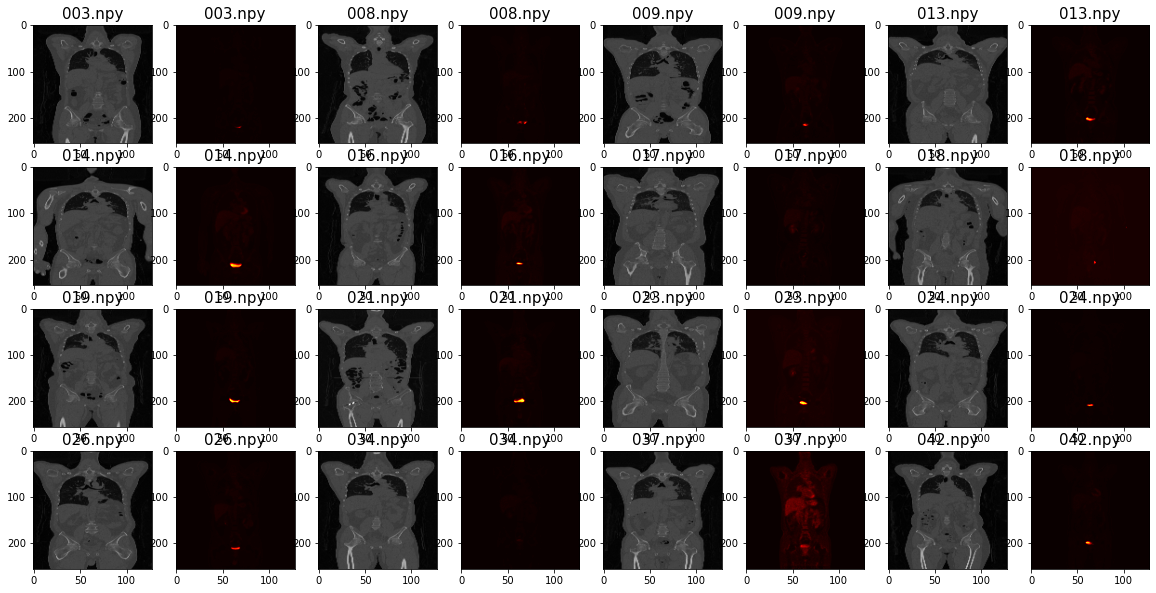

In [4]:
# Check (Vanilla)
from utils.common.plot import compare_plot
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_vanilla')
fig = plt.figure(figsize=(20,10))
compare_plot(PATH_1=CT_PATH, PATH_2=PT_PATH, fig=fig, grid=(4,8), vmax=[1, 1])

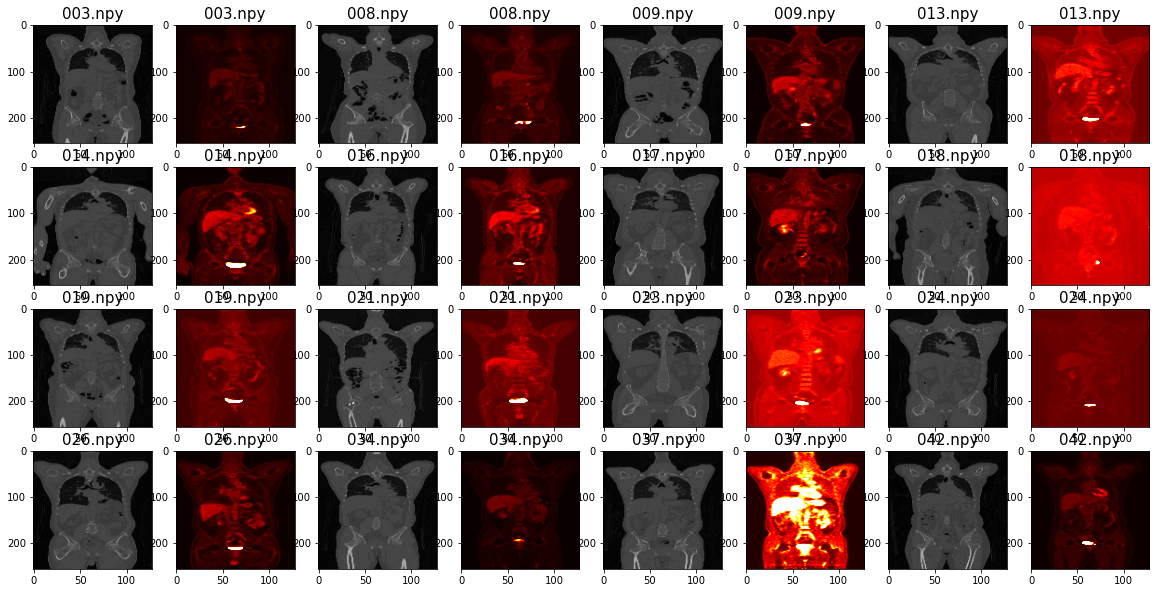

In [6]:
# Check (Resize)
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_resize')
fig = plt.figure(figsize=(20,10))
compare_plot(PATH_1=CT_PATH, PATH_2=PT_PATH, fig=fig, grid=(4,8), vmax=[1, 0.1])

## 2. VoxelMorph Baseline

In [3]:
# Data Generator Function
def vxm_data_generator(PATH_1, PATH_2, batch_size=32, shuffle=True):
    # Data : [M, X, Y, Z]
    
    # Generation
    # Input : moving-img [N, X, Y, Z, 1], fixed-img [N, X, Y, Z, 1]
    # Output : moved-img [N, X, Y, Z, 1], zero-grad [N, X, Y, Z, 3]
    PATH_1_list = os.listdir(PATH_1)
    PATH_2_list = os.listdir(PATH_2)
    
    # preliminary sizing
    sample_num = len(os.listdir(PATH_1)) # extract sample #
    vol_shape = np.load(os.path.join(PATH_1, PATH_1_list[0])).shape # extract data shape
    CT_input = np.zeros([sample_num, *vol_shape])
    PT_input = np.zeros([sample_num, *vol_shape])
    ndims = len(vol_shape)

    # load CT, PT Voxels
    for i in range(sample_num):
        CT_input[i] = np.load(os.path.join(PATH_1, PATH_1_list[i]))
        PT_input[i] = np.load(os.path.join(PATH_2, PATH_2_list[i]))
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    # iteration
    idx_list = np.array([])

    while True:
        # iteration check
        if len(idx_list) == 0:
            if shuffle: idx_list = np.random.permutation(sample_num)
            else: idx_list = np.arange(sample_num)

        # prepare inputs:
        # images need to be of the size [N, X, Y, Z, 1]
        idx = idx_list[:batch_size]
        idx_list = idx_list[batch_size:]
        moving_images = PT_input[idx, ..., np.newaxis]
        fixed_images = CT_input[idx, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # fixed_images : not used, just dummy data
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [4]:
# Train / Validation Set Generator
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_vanilla')
train_generator = vxm_data_generator(PATH_1=CT_PATH, PATH_2=PT_PATH, batch_size=1, shuffle=True)

In [5]:
# U-Net based unsupervised model (VxmDense)
# nb_features : unet convolutional features
# int_steps : number of flow integration steps; 0 = disables diffeomorphism
input_shape = (128, 128, 256)
nb_features = [
    [32, 32, 32, 32],           # Encoder Features
    [32, 32, 32, 32, 32, 16]    # Decoder Features
]

In [25]:
# Model Generation
model = vxm.networks.VxmDense(input_shape, nb_features, int_steps=0)

In [26]:
# Losses
# 'NCC' : Similarity
# Grad('l2') : Regularization
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
lambda_param = 1
loss_weights = [1, lambda_param]

In [27]:
# Complie
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=losses,
              loss_weights=loss_weights)

In [28]:
# Training
hist = model.fit(train_generator, epochs=10, steps_per_epoch=16, verbose=1)

Epoch 1/10
16/16 [==============================] - 42s 2s/step - loss: -0.0130 - transformer_loss: -0.0132 - flow_loss: 2.6807e-04
Epoch 2/10
16/16 [==============================] - 37s 2s/step - loss: -0.0129 - transformer_loss: -0.0131 - flow_loss: 1.2731e-04
Epoch 3/10
16/16 [==============================] - 38s 2s/step - loss: -0.0139 - transformer_loss: -0.0140 - flow_loss: 1.1236e-04
Epoch 4/10
16/16 [==============================] - 37s 2s/step - loss: -0.0126 - transformer_loss: -0.0141 - flow_loss: 0.0014
Epoch 5/10
16/16 [==============================] - 37s 2s/step - loss: -0.0131 - transformer_loss: -0.0150 - flow_loss: 0.0019
Epoch 6/10
16/16 [==============================] - 37s 2s/step - loss: -0.0132 - transformer_loss: -0.0133 - flow_loss: 1.0368e-04
Epoch 7/10
16/16 [==============================] - 37s 2s/step - loss: -0.0139 - transformer_loss: -0.0140 - flow_loss: 1.1925e-04
Epoch 8/10
16/16 [==============================] - 37s 2s/step - loss: -0.0143 - tr

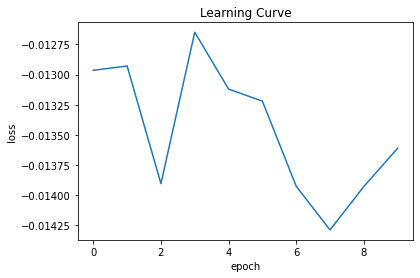

In [29]:
# Learning Curve
plt.figure()
plt.plot(hist.history['loss'])
plt.title('Learning Curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [39]:
result = model.evaluate([PT_input, CT_input])

1/1 [==============================] - 1s 751ms/step - loss: 0.0000e+00 - transformer_loss: 0.0000e+00 - flow_loss: 0.0000e+00


In [30]:
# Sample Validation
val_input, _ = next(train_generator)
val_pred = model.predict(val_input)

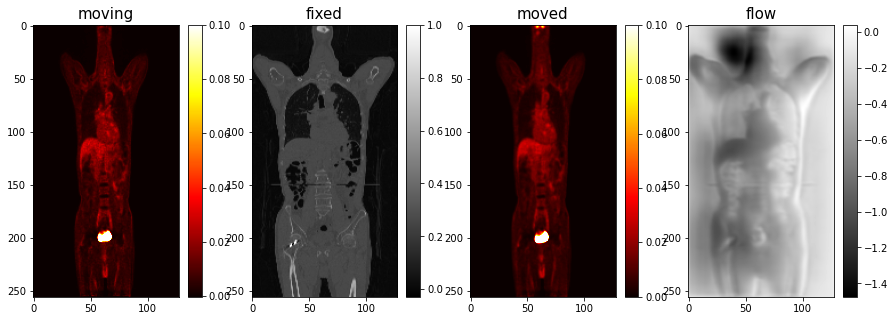

In [31]:
# Visualization
images = [img[0, 64, :, :, 0].T for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
cmap = [plt.cm.hot, plt.cm.gray, plt.cm.hot, plt.cm.gray]
vmax = [0.1, 1, 0.1, None]
fig = plt.figure(figsize=(15,5))
axes = []
for i in range(4):
    axes.append(fig.add_subplot(1,4,i+1))
    axes[-1].set_title(titles[i], fontsize=15)
    clr = plt.imshow(images[i], aspect='auto', cmap=cmap[i], vmax=vmax[i])
    fig.colorbar(clr)